# Hail Conv Net Filter Activations

This notebook contains the examples that activate each convolutional filter in the last layer of a hail neural net.

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import xarray as xr
from deepsky.data import load_storm_patch_data
from deepsky.gan import normalize_multivariate_data, unnormalize_multivariate_data
from scipy.ndimage import gaussian_filter
import yaml
from os.path import join, exists
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
config_file = "/glade/u/home/dgagne/deepsky/config/spatial_storm_model_config.yaml"
with open(config_file) as config_obj:
    config = yaml.load(config_obj)

Load storm data from netCDF and normalize it.

In [3]:
sess = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=False,
                                                       gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                       log_device_placement=False))
K.set_session(sess)

In [4]:
data_path = "/glade/work/dgagne/ncar_ens_storm_patches/"
input_variables = config["input_variables"]
num_proc = 4
print("Loading data")
storm_data, storm_meta = load_storm_patch_data(data_path, input_variables, num_proc)
storm_norm_data, storm_scaling_values = normalize_multivariate_data(storm_data)

Loading data
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc 3

In [5]:
output_config = config["output"]
output_data, output_meta = load_storm_patch_data(data_path,
                                                     [output_config["variable"],
                                                      output_config["mask"]], 4)
max_hail = np.array([output_data[i, :, :, 0][output_data[i, :, :, 1] > 0].max()
                         for i in range(output_data.shape[0])])
max_hail *= 1000
hail_labels = np.where(max_hail >= output_config["threshold"], 1, 0)

/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/glade/wor

1

In [6]:
model_path = "/glade/work/dgagne/spatial_storm_results_20171220/"
sample = 3
hail_cnn = load_model(join(model_path, "hail_conv_net_sample_{0:03d}.h5".format(sample)))
#log_pca = pickle.load(open(join(model_path, "hail_logistic_pca_sample_003.pkl"), 'rb'))

/glade/u/apps/dav/opt/python/3.6.4/intel/17.0.1/pkg-library/20180801-DL/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [27]:
storm_norm_data.reshape(-1, 32 * 32, 15)

array([-1.0258168 , -0.9994812 , -1.0258168 , ..., -1.0784881 ,
       -0.9204743 , -0.94680995], dtype=float32)

In [8]:
hail_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

In [9]:
dense_weights = hail_cnn.layers[-2].get_weights()[0].reshape(4,4,128)

In [7]:
dense_weights.mean(axis=0).mean(axis=0).argmax()

111

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  5.,  7.,  4.,  6., 12., 12.,
        10., 15., 17., 12.,  7., 12., 21., 13., 24., 20., 12., 12., 16.,
        16., 13., 19., 17.,  8., 14., 15., 10., 17., 16., 14., 20., 17.,
        14., 12., 12., 11.,  8.,  4.,  6.,  5.,  1.,  2.,  1.]),
 array([-0.0495921 , -0.04790518, -0.04621826, -0.04453134, -0.04284443,
        -0.04115751, -0.03947059, -0.03778367, -0.03609675, -0.03440983,
        -0.03272291, -0.03103599, -0.02934908, -0.02766216, -0.02597524,
        -0.02428832, -0.0226014 , -0.02091448, -0.01922756, -0.01754064,
        -0.01585373, -0.01416681, -0.01247989, -0.01079297, -0.00910605,
        -0.00741913, -0.00573221, -0.00404529, -0.00235838, -0.00067146,
         0.00101546,  0.00270238,  0.0043893 ,  0.00607622,  0.00776314,
         0.00945006,  0.01113697,  0.01282389,  0.01451081,  0.01619773,
         0.01788465,  0.01957157,  0.02125849,  0.02294541,  0.02463232,
         0.02631924,  0.02800616,  0.02969308,  0.03138   ,

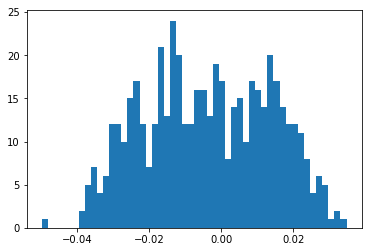

In [8]:
plt.hist(dense_weights[1:-1, 1:-1].ravel(), 50)

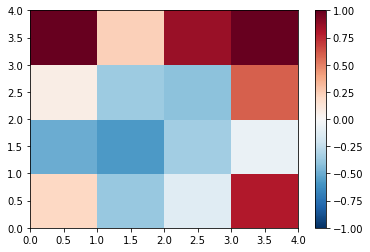

In [11]:
plt.pcolormesh(dense_weights.sum(axis=-1), vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar()

In [15]:
np.unravel_index(12, (4,4))

(3, 0)

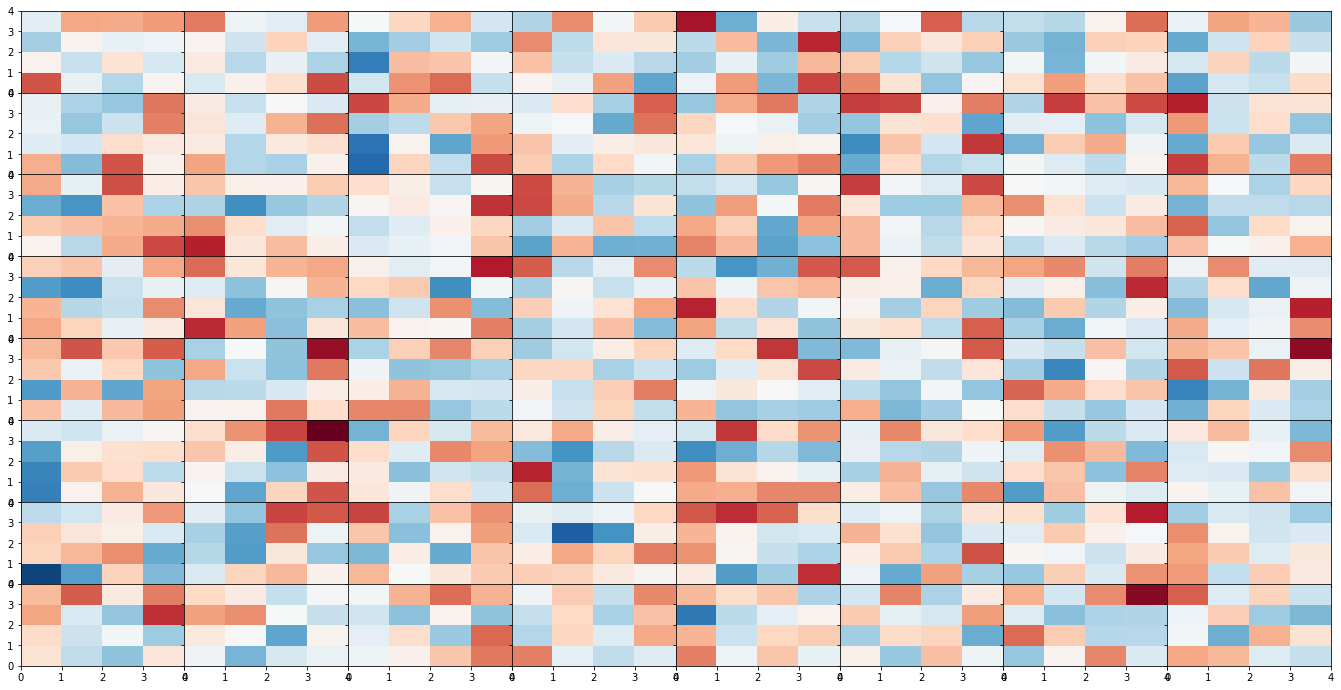

In [29]:
fig, axes = plt.subplots(8, 8, figsize=(20, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.03, 0.03, 0.94, 0.94, hspace=0, wspace=0)
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(dense_weights[:, :, a], vmin=-0.06, vmax=0.06, cmap="RdBu_r")

In [7]:
def activated_analogs(norm_data, hail_labels, cnn_model, num_analogs=16, filter_index=(0, 0), dense_layer_index=-2,
                      conv_layer_index=-6, batch_size=4096):
    """
    For a given convolutional neural network, identify the examples that most activate a given set of
    neurons in a convolutional layer.

    Args:
        norm_data: Normalized input data for the convolutional neural network
        cnn_model: Keras convolutional neural network model object
        num_analogs: Number of activated input examples to store for each neuron
        filter_index: Spatial array index of convolution filters being evaluated
        dense_layer_index: Index of the final dense layer that connects the convolutions and outputs
        conv_layer_index: Index of the activation of the final convolutional layer.

    Returns:
        dense_weights (array of weight values), top_analog_ids (input data indices associated with each neuron),
        top_analog_activations (the magnitude of the activation), top_analog_gradients (gradients with respect
        to the input for each of the top analogs)
    """
    dense_weights = pd.Series(cnn_model.layers[dense_layer_index].get_weights()[0].reshape(
        cnn_model.layers[conv_layer_index].output_shape[1:])[filter_index], name="Weights")
    top_analog_ids = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs), dtype=int),
                                  columns=["Analog_ID_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_activations = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs)),
                                          columns=["Analog_Act_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_gradients = np.zeros([dense_weights.shape[-1], num_analogs] + list(norm_data.shape[1:]))
    analog_rocs = pd.DataFrame(np.zeros((dense_weights.shape[-1], 2)), columns=["Positive_AUC", "Negative_AUC"])
    for w in range(dense_weights.shape[-1]):
        filter_out = cnn_model.layers[conv_layer_index].output[:, filter_index[0], filter_index[1], w]
        act_func = K.function([cnn_model.input, K.learning_phase()],
                              [filter_out])
        loss = (filter_out - 2) ** 2
        grad = K.gradients(loss, cnn_model.input)[0]
        grad /= K.maximum(K.std(grad), K.epsilon())
        grad_func = K.function([cnn_model.input, K.learning_phase()], [grad])
        max_acts = np.zeros(norm_data.shape[0])
        for b in range(0, norm_data.shape[0], batch_size):
            batch_slice = slice(b,np.minimum(b + batch_size, norm_data.shape[0]) )
            max_acts[batch_slice] = act_func([norm_data[batch_slice], 0])[0]
        scaled_acts = (max_acts - max_acts.min()) / (max_acts.max() - max_acts.min())
        analog_rocs.loc[w, "Positive_AUC"] = roc_auc_score(hail_labels, scaled_acts)
        analog_rocs.loc[w, "Negative_AUC"] = roc_auc_score(hail_labels, 1-scaled_acts)
        top_analog_ids.loc[w] = np.argsort(max_acts)[::-1][:num_analogs]
        top_analog_activations.loc[w] = max_acts[top_analog_ids.loc[w]]
        top_analog_gradients[w] = grad_func([norm_data[top_analog_ids.loc[w]], 0])[0]
        print(w, dense_weights[w], analog_rocs.loc[w])
    combined_info = pd.concat([top_analog_ids, top_analog_activations, dense_weights, analog_rocs], axis=1)
    return combined_info, top_analog_gradients

In [10]:
analog_info, analog_gradients = activated_analogs(storm_norm_data, hail_labels, hail_cnn, filter_index=(3, 0))

0 -0.006644886 Positive_AUC    0.315716
Negative_AUC    0.684284
Name: 0, dtype: float64
1 0.031094193 Positive_AUC    0.347047
Negative_AUC    0.652953
Name: 1, dtype: float64
2 -0.0003006775 Positive_AUC    0.375168
Negative_AUC    0.624832
Name: 2, dtype: float64
3 -0.017957611 Positive_AUC    0.497618
Negative_AUC    0.502382
Name: 3, dtype: float64
4 0.04983119 Positive_AUC    0.439392
Negative_AUC    0.560608
Name: 4, dtype: float64
5 -0.016506588 Positive_AUC    0.489607
Negative_AUC    0.510393
Name: 5, dtype: float64
6 -0.014543196 Positive_AUC    0.257665
Negative_AUC    0.742335
Name: 6, dtype: float64
7 -0.0038018874 Positive_AUC    0.629214
Negative_AUC    0.370786
Name: 7, dtype: float64
8 -0.0044930736 Positive_AUC    0.307195
Negative_AUC    0.692805
Name: 8, dtype: float64
9 0.0047600796 Positive_AUC    0.366486
Negative_AUC    0.633514
Name: 9, dtype: float64
10 0.039869763 Positive_AUC    0.410046
Negative_AUC    0.589954
Name: 10, dtype: float64
11 -0.0092736855 Pos

In [34]:
data_acts = np.zeros((storm_norm_data.shape[0], 2))
batch_size = 1024
for i, w in enumerate([104, 38]):
    filter_out = hail_cnn.layers[-6].output[:, 1, 1, w]
    act_func = K.function([hail_cnn.input, K.learning_phase()],
                              [filter_out])
    for b in range(0, storm_norm_data.shape[0], batch_size):
        print(b)
        batch_slice = slice(b,np.minimum(b + batch_size, storm_norm_data.shape[0]) )
        data_acts[batch_slice, i] = act_func([storm_norm_data[batch_slice], 0])[0]

0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936
40960
41984
43008
44032
45056
46080
47104
48128
49152
50176
51200
52224
53248
54272
55296
56320
57344
58368
59392
60416
61440
62464
63488
64512
65536
66560
67584
68608
69632
70656
71680
72704
73728
74752
75776
76800
77824
78848
79872
80896
81920
82944
83968
84992
86016
87040
88064
89088
90112
91136
92160
93184
94208
95232
96256
97280
98304
99328
100352
101376
102400
103424
104448
105472
106496
107520
108544
109568
110592
111616
112640
113664
0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936
40960
41984
43008
44032
45056
46080
47104
48128
49152
50176
51200
52224
53248
54272
55296
56320
5734

In [56]:
analog_info["Positive_AUC"].argsort()[::-1]

127     94
126    114
125     27
124     61
123     48
122     38
121     64
120     98
119    124
118     73
117     96
116     15
115    115
114      3
113     20
112    106
111    126
110     53
109      7
108     51
107     34
106     19
105     32
104     62
103     66
102     86
101    113
100     72
99       2
98      37
      ... 
29     122
28       1
27      42
26     110
25      11
24     121
23      36
22      80
21      84
20      13
19      25
18      33
17      29
16      47
15      39
14     104
13      35
12      75
11       6
10     102
9      118
8       79
7       41
6       99
5      107
4      116
3       49
2       31
1      125
0       93
Name: Positive_AUC, Length: 128, dtype: int64

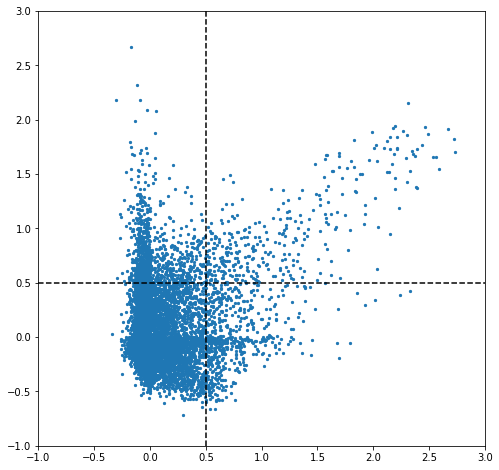

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(data_acts[:, 0], data_acts[:, 1], 5)
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.plot(np.ones(10) * 0.5, np.linspace(-1, 3, 10), 'k--')
plt.plot(np.linspace(-1, 3, 10), np.ones(10) * 0.5,  'k--')

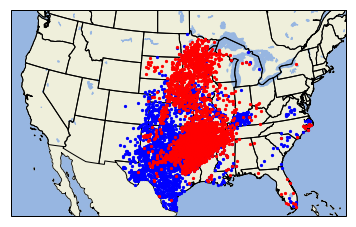

In [35]:
crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.LambertConformal())
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS["water"])
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "50m",
                                          edgecolor="k", facecolor="none")
lakes_50m = cfeature.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="face",
                                         facecolor=cfeature.COLORS["water"])
ax.add_feature(ocean_50m, zorder=1)
ax.add_feature(land_50m, zorder=2)
ax.add_feature(lakes_50m, zorder=2)
ax.add_feature(states_50m, zorder=3)
ax.coastlines('50m', linewidth=0.8, zorder=4)
idxs = data_acts[:, 0] > 1
idxs_2 = data_acts[:, 1] > 1
ax.scatter(storm_meta.loc[idxs_2, "center_lon"], storm_meta.loc[idxs_2, "center_lat"], 5, "blue", transform=crs, zorder=5)
ax.scatter(storm_meta.loc[idxs, "center_lon"], storm_meta.loc[idxs, "center_lat"], 5, "red",transform=crs, zorder=6)
ax.set_extent((-120, -74, 23, 50))

In [38]:
idxs = data_acts[:, 0] > 0.5
idxs_2 = data_acts[:, 1] > 0.5
lons = np.arange(-120, -74.25, 0.5)
lats = np.arange(20, 50.25, 0.5)
lon_grid, lat_grid = np.meshgrid(lons, lats)
out_points = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T
kd1 = KernelDensity(bandwidth=2, metric="euclidean")
kd1.fit(storm_meta.loc[idxs, ["center_lat", "center_lon"]])
kd2 = KernelDensity(bandwidth=2, metric="euclidean")
kd2.fit(storm_meta.loc[idxs_2,["center_lat", "center_lon"]])
out_1 = np.exp(kd1.score_samples(out_points))
out_2 = np.exp(kd2.score_samples(out_points))

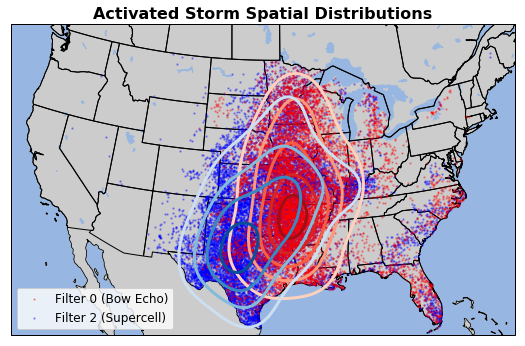

In [41]:
fig = plt.figure(figsize=(10, 6))
crs = ccrs.PlateCarree()
ax = fig.add_axes([0, 0, 0.7, 1], projection=ccrs.LambertConformal())
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="0.8")
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS["water"])
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "50m",
                                          edgecolor="k", facecolor="none")
lakes_50m = cfeature.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="face",
                                         facecolor=cfeature.COLORS["water"])
ax.add_feature(ocean_50m, zorder=1)
ax.add_feature(land_50m, zorder=2)
ax.add_feature(lakes_50m, zorder=2)
ax.add_feature(states_50m, zorder=3)
ax.coastlines('50m', linewidth=0.8, zorder=4)

ax.scatter(storm_meta.loc[idxs, "center_lon"], storm_meta.loc[idxs, "center_lat"], 2, "red", alpha=0.3, 
           transform=crs, zorder=6, label="Filter 0 (Bow Echo)")
ax.scatter(storm_meta.loc[idxs_2, "center_lon"], storm_meta.loc[idxs_2, "center_lat"], 
           2, "blue", alpha=0.3, transform=crs, zorder=5, label="Filter 2 (Supercell)")
plt.contour(lon_grid, lat_grid, out_1.reshape(lon_grid.shape), 
            5, vmin=np.percentile(out_2, 10), vmax=out_1.max(), transform=crs, 
            zorder=6, linewidths=3, cmap="Reds", )
plt.contour(lon_grid, lat_grid, out_2.reshape(lon_grid.shape), 
            5, vmin=np.percentile(out_2, 10), vmax=out_2.max(), transform=crs, 
            zorder=6, linewidths=3, cmap="Blues", )
ax.set_extent((-120, -74, 23, 50))
ax.legend(loc=0, fontsize=12)
ax.set_title("Activated Storm Spatial Distributions", fontsize=16, fontweight="bold")
plt.savefig("activation_spatial_dist.pdf", bbox_inches="tight")

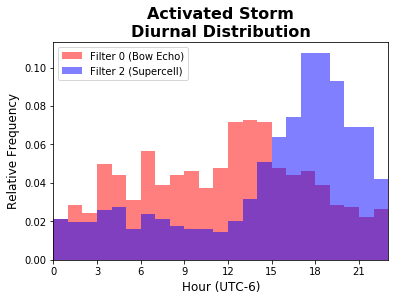

In [30]:
fig, ax_2 = plt.subplots(1, 1, figsize=(6, 4))
ax_2.hist((pd.DatetimeIndex(storm_meta.loc[idxs, "valid_dates"]).hour - 6) % 24, np.arange(0, 25), 
          alpha=0.5, color="red", density=True, lw=2, label="Filter 0 (Bow Echo)")
ax_2.hist((pd.DatetimeIndex(storm_meta.loc[idxs_2, "valid_dates"]).hour - 6) % 24, np.arange(0, 25), 
         alpha=0.5, color="blue", density=True, lw=2, label="Filter 2 (Supercell)")
ax_2.set_xticks(np.arange(0, 24, 3))
ax_2.set_xlim(0, 23)
ax_2.legend(loc=0)
ax_2.set_xlabel("Hour (UTC-6)", fontsize=12)
ax_2.set_ylabel("Relative Frequency", fontsize=12)
ax_2.set_title("Activated Storm\nDiurnal Distribution", fontsize=16, fontweight="bold")
plt.savefig("activation_hour_dist.pdf", bbox_inches="tight")

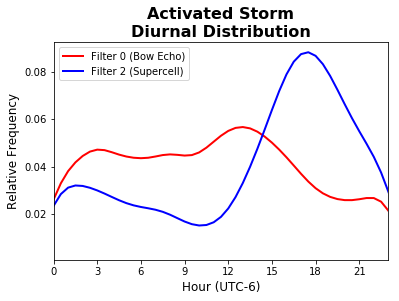

In [42]:
fig, ax_2 = plt.subplots(1, 1, figsize=(6, 4))
kd_time_0 = KernelDensity(bandwidth=1)
kd_time_0.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs, "valid_dates"]).hour - 6) % 24, axis=1))
kd_time_1 = KernelDensity()
kd_time_1.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs_2, "valid_dates"]).hour - 6) % 24, axis=1))
times = np.arange(0, 25, 0.5)
ax_2.plot(times, np.exp(kd_time_0.score_samples(times.reshape(-1, 1))), color="red", linewidth=2, label="Filter 0 (Bow Echo)")
ax_2.plot(times, np.exp(kd_time_1.score_samples(times.reshape(-1, 1))), color="blue", linewidth=2, label="Filter 2 (Supercell)")
ax_2.set_xticks(np.arange(0, 24, 3))
ax_2.set_xlim(0, 23)
ax_2.legend(loc=0)
ax_2.set_xlabel("Hour (UTC-6)", fontsize=12)
ax_2.set_ylabel("Relative Frequency", fontsize=12)
ax_2.set_title("Activated Storm\nDiurnal Distribution", fontsize=16, fontweight="bold")
plt.savefig("activation_hour_dist_kde.pdf", bbox_inches="tight")

In [8]:
analog_info["Weights"].sort_values()[::-1]

104    0.023381
51     0.022972
38     0.022918
112    0.022721
72     0.021976
45     0.021024
32     0.020852
34     0.020708
48     0.020127
83     0.018656
2      0.018413
16     0.018054
102    0.017466
13     0.017209
46     0.016788
15     0.015904
30     0.015842
55     0.015734
53     0.015707
40     0.015479
14     0.015343
119    0.015270
62     0.015188
20     0.014300
80     0.014081
7      0.013670
73     0.013123
115    0.013066
59     0.012729
108    0.011689
         ...   
98    -0.018986
29    -0.020339
70    -0.020948
66    -0.022611
37    -0.023456
23    -0.023547
117   -0.023817
101   -0.024369
87    -0.024438
90    -0.024749
71    -0.024775
42    -0.024912
103   -0.026975
99    -0.027146
6     -0.028051
93    -0.028173
43    -0.028401
39    -0.028413
107   -0.028464
63    -0.029150
121   -0.030057
86    -0.030105
125   -0.030241
25    -0.030310
116   -0.030411
88    -0.031509
69    -0.033407
49    -0.033704
65    -0.034704
100   -0.037076
Name: Weights, Length: 1

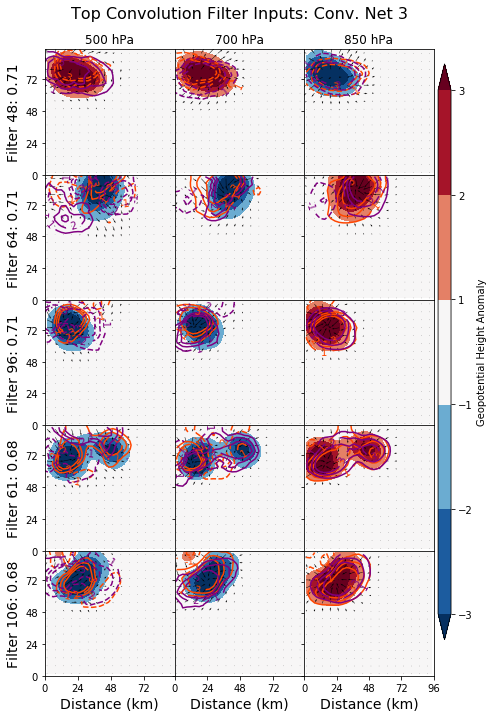

In [27]:
fig, axes = plt.subplots(5, 3, figsize=(6, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.92, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
#ranked_weights = analog_info["Weights"].sort_values()[::-1].index
ranked_weights = analog_info["Positive_AUC"].argsort()[::-1].values
p_levels = [500, 700, 850]
for at in range(3):
    axes[0, at].set_title(f"{p_levels[at]:d} hPa")
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    height_g = gaussian_filter(-analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1)
    height_g /= height_g.std()
    hght = ax.contourf(np.arange(0.5, 32), np.arange(0.5, 32), 
                 height_g, 
                contours, extend="both", cmap="RdBu_r")
    temp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1)
    temp_g /= temp_g.std()
    tc = ax.contour(np.arange(0.5, 32), np.arange(0.5, 32),
                    temp_g, contours, colors="orangered")
    ax.clabel(tc, fmt="%0.0f")
    dewp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1)
    dewp_g /= dewp_g.std()
    dc = ax.contour(dewp_g, contours, colors="purple")
    ax.clabel(dc, fmt="%0.0f")
    u_g = gaussian_filter(-analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 2)
    v_g = gaussian_filter(-analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 2)
    u_g /= u_g.std()
    v_g /= v_g.std()
    ax.quiver(np.arange(0.5, 32, 2), np.arange(0.5, 32, 2),
              u_g[::2, ::2], v_g[::2, ::2], scale=64)
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.2f}".format(ranked_weights[w], analog_info.loc[ranked_weights[w], "Positive_AUC"]),
                  fontsize=14)
    ax.set_yticks(np.arange(0, 36, 8))
    ax.set_yticklabels(np.arange(0, 36, 8) * 3)
    ax.set_xticks(np.arange(0, 36, 8))
    ax.set_xticklabels( np.arange(0, 36, 8) * 3)

    if w == 4:
        ax.set_xlabel("Distance (km)".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
cax = fig.add_axes([0.96, 0.1, 0.03, 0.8])
fig.colorbar(hght, cax=cax, label="Geopotential Height Anomaly")
plt.suptitle("Top Convolution Filter Inputs: Conv. Net {0:d}".format(sample), fontsize=16)
plt.savefig("top_auc_filter_gradients_{0:02d}.pdf".format(sample), dpi=300, bbox_inches="tight")

In [21]:
analog_info["Negative_AUC"].argsort()[::-1]

127     31
126    104
125      6
124     80
123     82
122     93
121     59
120    103
119     83
118     39
117    118
116    125
115    116
114    102
113     49
112     79
111     47
110     16
109     14
108     84
107      8
106     97
105     99
104    111
103      0
102     13
101     67
100    105
99      60
98      50
      ... 
29       5
28      15
27      76
26       3
25     126
24      27
23      37
22      52
21      73
20      87
19      88
18      72
17      65
16     114
15     124
14      20
13      86
12     115
11      98
10      30
9       57
8       56
7       62
6        7
5       53
4      106
3       61
2       96
1       64
0       48
Name: Negative_AUC, Length: 128, dtype: int64

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


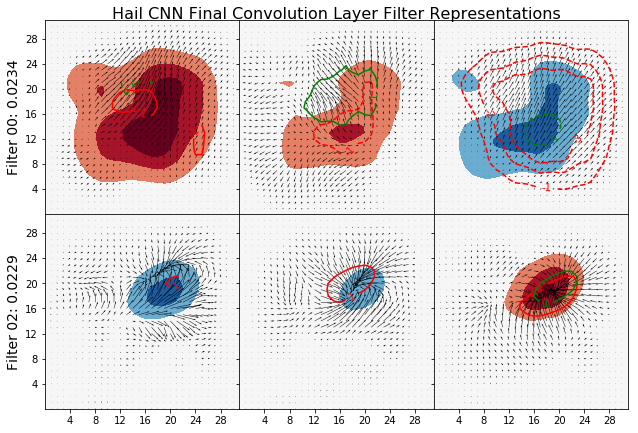

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.95, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
ranked_weights = analog_info["Weights"].sort_values()[::-1].index[[0,2]]
f_number = [0, 2]
p_levels = [500, 700, 850]
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    ax.contourf(gaussian_filter(analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1), contours, extend="both", cmap="RdBu_r")
    tc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1), contours, colors="red")
    ax.clabel(tc, fmt="%0.0f")
    dc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1), contours, colors="green")
    ax.clabel(dc, fmt="%0.0f")
    ax.quiver(gaussian_filter(analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 1),
             gaussian_filter(analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 1))
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.4f}".format(f_number[w], analog_info.loc[ranked_weights[w], "Weights"]),
                  fontsize=14)
    ax.set_yticks(np.arange(4, 32, 4))
    ax.set_xticks(np.arange(4, 32, 4))
    if w == 5:
        ax.set_xlabel("{0:d} mb".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
plt.suptitle("Hail CNN Final Convolution Layer Filter Representations", fontsize=16)
plt.savefig("top_filter_gradients_{0:02d}_reduced.pdf".format(sample), dpi=300, bbox_inches="tight")

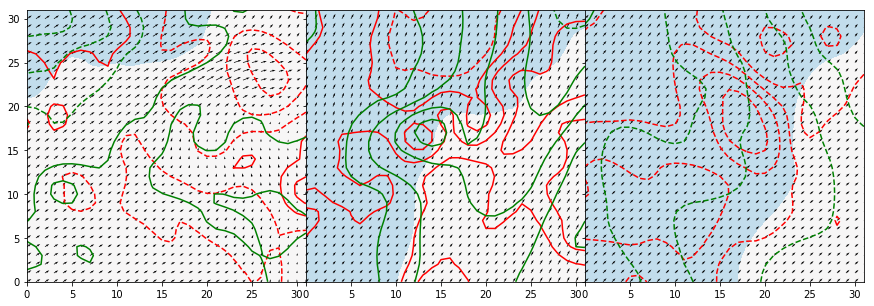

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = [-3, -2, -1, -0.5, 0.5, 1, 2, 3]
weight = 97
weight_analogs = analog_info.iloc[weight, 0:16].values.astype(int)
for a, ax in enumerate(axes):
    ax.contourf(gaussian_filter(storm_norm_data[weight_analogs, :, :, 0 + a][1], 1), contours, extend="both", cmap="RdBu_r")
    ax.contour(gaussian_filter(storm_norm_data[weight_analogs, :, :, 3 + a][1], 1), 5, colors="red")
    ax.contour(gaussian_filter(storm_norm_data[weight_analogs, :, :, 6 + a][1], 1), 5, colors="green")
    ax.quiver(gaussian_filter(storm_norm_data[weight_analogs, :, :, 9 + a][1], 1),
             gaussian_filter(storm_norm_data[weight_analogs, :, :, 12 + a][1], 1))

In [16]:
num_ex = 16
top_max_example_ids = np.zeros((dense_weights.shape[-1], num_ex), dtype=int)
top_max_acts = np.zeros((dense_weights.shape[-1], num_ex))
top_max_gradients = np.zeros((dense_weights.shape[-1], num_ex, 32, 32, 15))

for w in range(dense_weights.shape[-1]):
    print(w)
    act_func = K.function([hail_cnn.input, K.learning_phase()], 
                          [hail_cnn.layers[-6].output[:, 3, 0, w]])
    max_loss = (hail_cnn.layers[-6].output[:, 3, 0, w]- 4) ** 2
    max_grad = K.gradients(max_loss, hail_cnn.input)
    max_grad_func = K.function([hail_cnn.input, K.learning_phase()], max_grad)
    max_acts = act_func([storm_norm_data, 0])[0]
    top_max_example_ids[w] = np.argsort(max_acts)[::-1][:num_ex]
    top_max_acts[w] = max_acts[top_max_example_ids[w]]
    top_max_gradients[w] = max_grad_func([storm_norm_data[top_max_example_ids[w]]])[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [35]:
hail_cnn.layers[-6].output[:, :, :, 4]

<tf.Tensor 'strided_slice_129:0' shape=(?, 4, 4) dtype=float32>

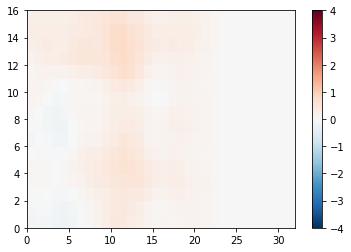

In [134]:
plt.pcolormesh(gaussian_filter(top_max_gradients[63,:, :, :, 2].mean(axis=1) / top_max_gradients[63].std(), 1), 
               vmin=-4, vmax=4, cmap="RdBu_r")
plt.colorbar()

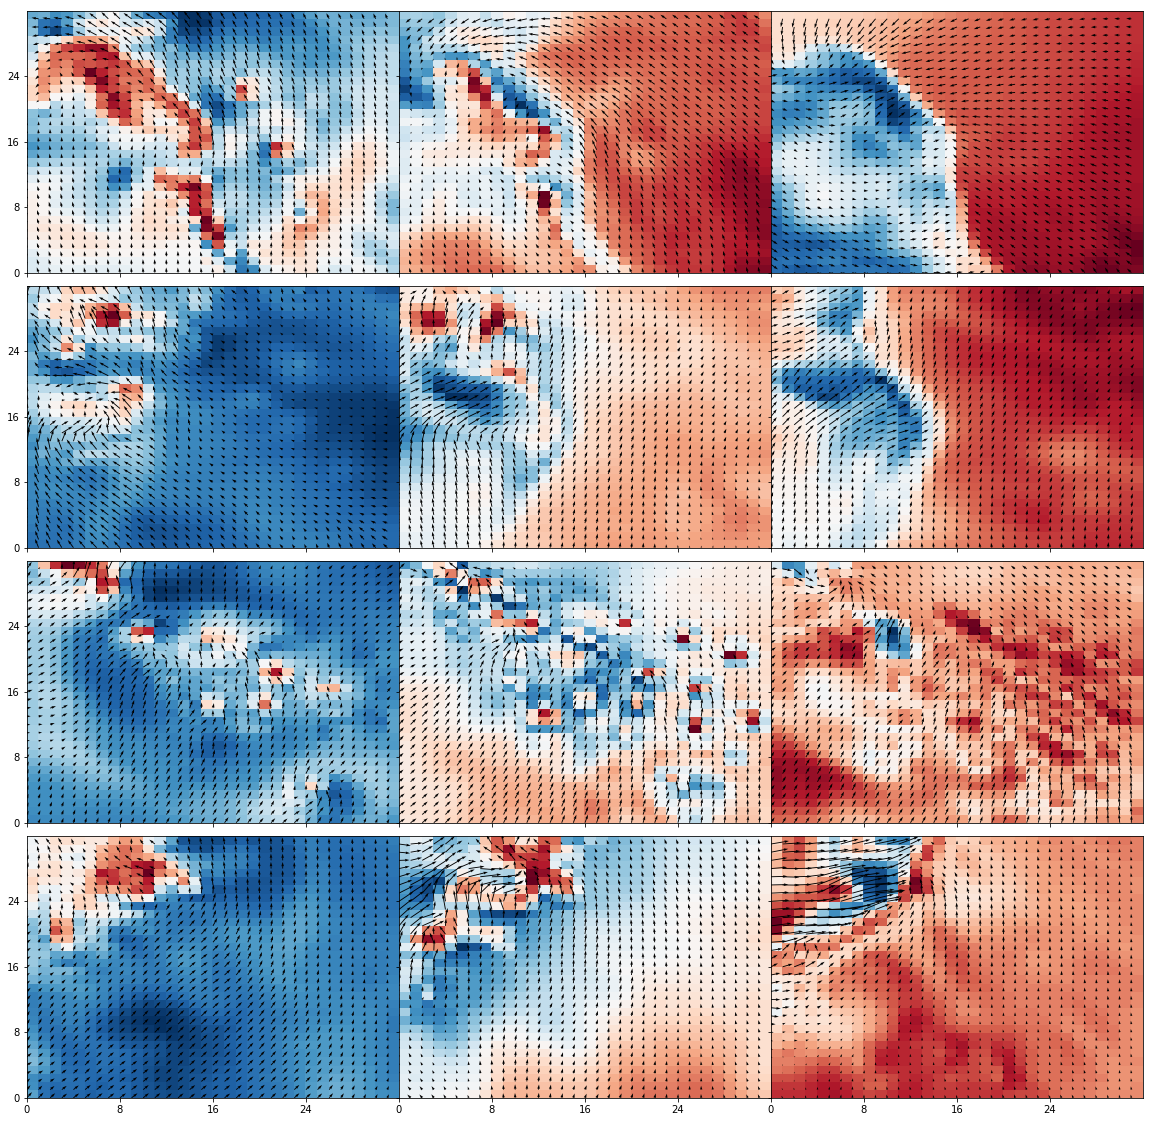

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3])
for w, ex_id in enumerate(top_max_example_ids[42][:4]):
    for l in range(3):
        axes[w, l].pcolormesh(storm_norm_data[ex_id, :, :, 3 + l], cmap="RdBu_r")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 3 + l], contours, colors="red")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 6 + l], contours, colors="green")
        axes[w, l].quiver(storm_norm_data[ex_id, :, :, 9 + l], storm_norm_data[ex_id, :, :, 12 + l])
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

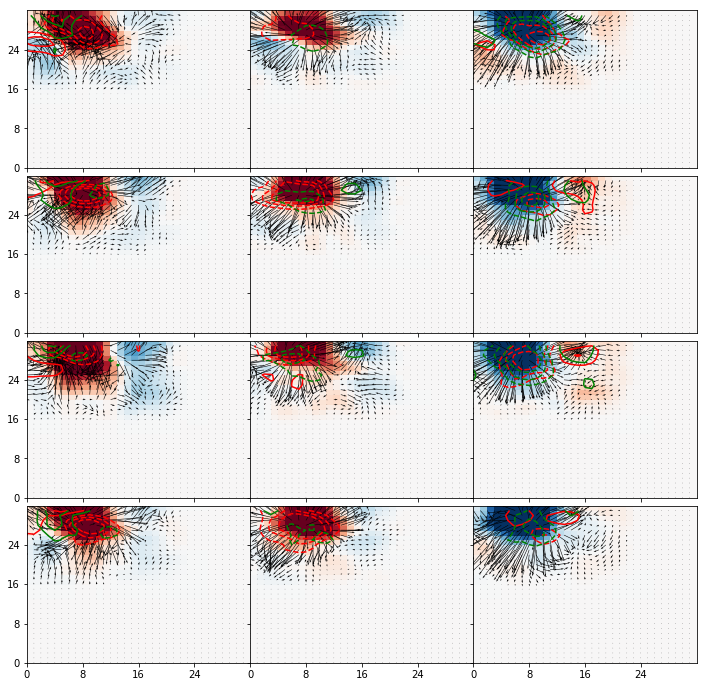

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
for w, ex_id in enumerate(top_max_example_ids[c_filter][:4]):
    scale = top_max_gradients[c_filter, w].std()
    for l in range(3):
        axes[w, l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, w, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 3 + l] / scale, 1), contours, colors="red")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 6 + l]/ scale, 1), contours, colors="green")
        axes[w, l].quiver(gaussian_filter(top_max_gradients[c_filter, w, :, :, 9 + l] / scale, 1) , 
                          gaussian_filter(top_max_gradients[c_filter, w, :, :, 12 + l] / scale,1))
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

ValueError: too many values to unpack (expected 2)

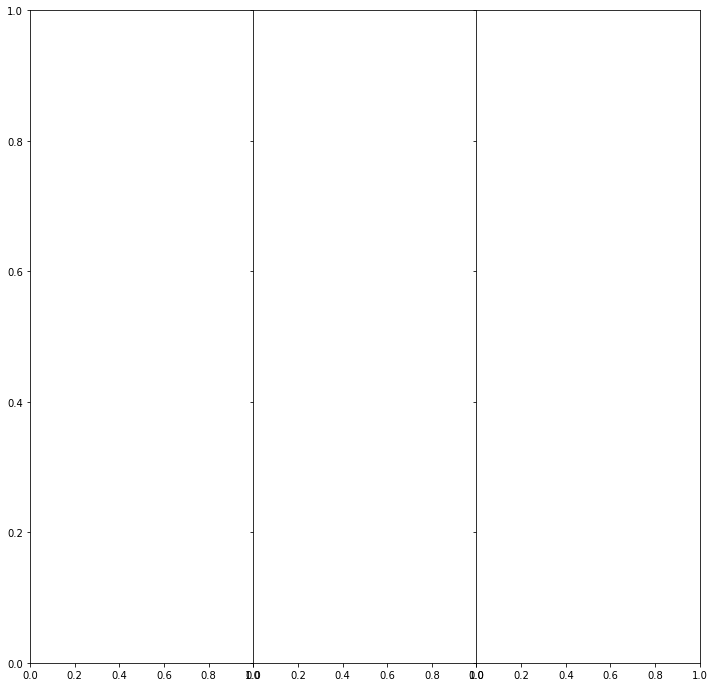

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
scale = top_max_gradients[c_filter].std()
w = 0
for l in range(3):
    axes[l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, :, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 3 + l].mean(axis=1) / scale, 1), contours, colors="red")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 6 + l].mean(axis=1)/ scale, 1), contours, colors="green")
    axes[l].quiver(gaussian_filter(top_max_gradients[c_filter, :, :, :, 9 + l].mean(axis=1) / scale, 1) , 
                      gaussian_filter(top_max_gradients[c_filter, :, :, :, 12 + l].mean(axis=1) / scale,1))
    axes[l].set_yticks(np.arange(0, 32, 8))
    axes[l].set_xticks(np.arange(0, 32, 8))

In [146]:
dense_weights[0, 0].argmax()

90

In [86]:
top_max_example_ids[63]

array([4477, 4468, 4476, 4469,  959,  960, 4466, 5119,  930,  958, 1017,
        975,  928,  990,  961,  929])

In [138]:
top_max_gradients[0, w, :, :, 9 + l].shape

(32, 32)